# C3DIS simulation autoencoder experiments

Plots:

- Accuracy of naive bayes on (autoencoder, deconvolving autoencoder)
- Number of training points vs accuracy for each
- Distance between peaks vs complexity score

In [1]:
import numpy, matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import torch, torch.nn as nn, torch.optim as optim
import scipy.ndimage
from cmocean import cm
from sklearn.decomposition import PCA
import sklearn.model_selection
import sklearn.naive_bayes
import sklearn.metrics
import sklearn.linear_model
import sklearn.svm

In [2]:
torch.cuda.get_device_name(torch.cuda.current_device())

'GeForce GTX 1080'

In [330]:
class E2E(nn.Module):
    loss_fn = nn.BCELoss()

    def __init__(self, n_channels):
        super().__init__()
        self.n_channels = n_channels

        # N x 1000 x 2
        self.conv = nn.Sequential(
            nn.Conv1d(2, 64, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(64, 16, 5, padding=2),
            nn.ReLU(),
        )
        
        self.linear = nn.Linear(16 * n_channels, 2)
        self.activation = nn.Softmax()
    
    def forward(self, x):
        res = self.linear(self.conv(x).view(-1, 16 * self.n_channels))
        return self.activation(res)

In [155]:
class DeconvolvingAutoencoder(nn.Module):
    loss_fn = nn.MSELoss()

    def __init__(self, rmsf, n_channels, n_components):
        super().__init__()
        self.n_components = n_components
        self.n_channels = n_channels
        self.real_rmsf = torch.from_numpy(rmsf.real.reshape(1, 1, -1)).float()
        self.imag_rmsf = torch.from_numpy(rmsf.imag.reshape(1, 1, -1)).float()
        
        # N x 1000 x 2
        self.encode = nn.Sequential(
            nn.Conv1d(2, 8, 5, padding=2),
            nn.Tanh(),
            nn.Conv1d(8, 16, 5, padding=2),
            nn.Tanh(),
        )
        
        self.linear_encode = nn.Linear(16 * n_channels, n_components)
        self.linear_decode = nn.Linear(n_components, 16 * n_channels)

        self.decode = nn.Sequential(
            nn.ConvTranspose1d(16, 8, 5, padding=2),
            nn.Tanh(),
            nn.ConvTranspose1d(8, 2, 5, padding=2),
            nn.Tanh(),
        )

        self.deconv_1 = nn.Sequential(
            nn.Conv1d(2, 64, 3, padding=1),
            nn.Tanh(),
            nn.Conv1d(64, 16, 3, padding=1),
            nn.Tanh(),
        )
        self.linear_deconv_1 = nn.Linear(16 * n_channels, n_components)
        self.linear_deconv_2 = nn.Linear(n_components, 16 * n_channels)
        self.deconv_2 = nn.Sequential(
            nn.ConvTranspose1d(16, 64, 3, padding=1),
            nn.Tanh(),
            nn.ConvTranspose1d(64, 2, 3, padding=1),
        )
    
        self.final_activation = nn.Tanh()
    
    def conv_RMSF(self, x):
        x_real = x[:, 0, :].view((x.shape[0], 1, x.shape[2]))
        x_imag = x[:, 1, :].view((x.shape[0], 1, x.shape[2]))
        conv_real = nn.functional.conv1d(x_real, self.real_rmsf, padding=self.n_channels // 2)
        conv_imag = nn.functional.conv1d(x_imag, self.imag_rmsf, padding=self.n_channels // 2)
        return torch.cat([conv_real, conv_imag], dim=1)[:, :, :-1]
    
    def encode_dirty(self, x):
        conv = self.conv_RMSF(x)
        encoded = self.linear_encode(self.encode(conv).view(-1, 16 * self.n_channels))
        return encoded
    
    def encode_clean(self, x):
        conv = self.conv_RMSF(x)
        encoded = self.linear_encode(self.encode(conv).view(-1, 16 * self.n_channels))
        recon = self.decode(self.linear_decode(encoded).view(-1, 16, self.n_channels))
        deconv1 = self.linear_deconv_1(self.deconv_1(recon).view(-1, 16 * self.n_channels))
        return deconv1

    def forward(self, x):
        conv = self.conv_RMSF(x)
        encoded = self.linear_encode(self.encode(conv).view(-1, 16 * self.n_channels))
        recon = self.decode(self.linear_decode(encoded).view(-1, 16, self.n_channels))
        deconv1 = self.linear_deconv_1(self.deconv_1(recon).view(-1, 16 * self.n_channels))
        deconv = self.deconv_2(self.linear_deconv_2(deconv1).view(-1, 16, self.n_channels))
#         deconv = self.deconv(self.linear_deconv(recon.view(-1, 2 * self.n_channels)).view(-1, 16, self.n_channels))
        activ = self.final_activation(deconv)
        return conv, recon, activ
    
    @classmethod
    def loss(cls, init, conv, conv_recon, init_recon, alpha=0.5, l1_reg=0):
        loss_conv = cls.loss_fn(conv_recon, conv)
        loss_e2e = cls.loss_fn(init_recon, init)
            
        return loss_conv * alpha + (1 - alpha) * loss_e2e + l1_reg * abs(init_recon).sum()

In [399]:
min_phi = -1000
max_phi = 1000
phi_padding = 25
phi_sampling = 300
max_noise = 0.005
n_spectra = 10000
max_N = 20000

# Generate some Faraday spectra for this epoch.

# True parameters: peak positions, amplitudes, and phases.
depths = numpy.random.randint(phi_padding, phi_sampling - phi_padding, size=(n_spectra, 2))
amps = numpy.random.uniform(0, 1, size=(n_spectra, 2))
simple = numpy.random.binomial(1, 0.5, size=(n_spectra,)).astype(bool)
amps[simple, 1] = 0
print(amps[simple].sum(axis=0))
phases = numpy.random.uniform(-numpy.pi, numpy.pi, size=(n_spectra, 2))
# spectra stores the real and imaginary components.
spectra = numpy.zeros((n_spectra, 2, phi_sampling))

for i in tqdm(range(n_spectra)):
    for p in range(2):
        if p == 1:
            if simple[i] and amps[i, p]:
                print(simple[i], amps[i, :])
                raise RuntimeError()
        spectra[i, 0, depths[i, p]] = amps[i, p] * numpy.cos(phases[i, p])
        spectra[i, 1, depths[i, p]] = amps[i, p] * numpy.sin(phases[i, p])
#     spectra[numpy.arange(n_spectra), 0, depths[:, p]] = amps[:, p] * numpy.cos(phases[:, p])
#     spectra[numpy.arange(n_spectra), 1, depths[:, p]] = amps[:, p] * numpy.sin(phases[:, p])
# Blur this to get the "groundtruth".
spectra_blurred = scipy.ndimage.gaussian_filter1d(spectra, sigma=3, axis=-1)
# Add noise to get the input.
spectra_noisy = spectra + numpy.random.normal(scale=max_noise,
                                              size=spectra.shape)
torch_X = torch.from_numpy(spectra_noisy).float()[:max_N]
torch_T = torch.from_numpy(spectra_blurred).float()[:max_N]

[2449.85076801    0.        ]


In [400]:
spectra_conv = DeconvolvingAutoencoder(rmsf, phi_sampling, 64).conv_RMSF(
    torch.from_numpy(spectra_noisy).float()).numpy()

In [401]:
spectra_conv_ = spectra_conv.reshape((-1, phi_sampling * 2))

In [402]:
pca = sklearn.decomposition.PCA(n_components=64)
pca_features = pca.fit_transform(spectra_conv_)

In [403]:
phi_samp, rmsf = numpy.loadtxt('dae/rmsf.txt', dtype=complex).T
phis = numpy.linspace(min_phi, max_phi, phi_sampling)
rmsf = numpy.interp(phis, phi_samp.astype(float), rmsf)
dcae = DeconvolvingAutoencoder(rmsf, 300, 64).float()
e2e = E2E(300).float()
optimiser_dcae = optim.Adam(dcae.parameters(), lr=1e-3)
optimiser_e2e = optim.Adam(e2e.parameters(), lr=1e-4)
losses_dcae = []
losses_e2e = []

# %matplotlib inline
phis = phis.astype(float)
# plt.plot(phis, rmsf.real); plt.plot(phis, rmsf.imag)


dcae.load_state_dict(torch.load('/home/alg010/Downloads/dcae_2019-04-29 11-20-16.557153.model'))
dcae.eval();

/home/alg010/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  This is separate from the ipykernel package so we can avoid doing imports until


In [404]:
torch_X_conv = torch.from_numpy(spectra_conv)[:max_N]
torch_X_conv.shape

torch.Size([10000, 2, 300])

In [405]:
torch_labels = torch.from_numpy(numpy.stack([simple, 1 - simple]).T).float()
print(torch_labels)

tensor([[0., 1.],
        [1., 0.],
        [1., 0.],
        ...,
        [0., 1.],
        [0., 1.],
        [1., 0.]])


# Sanity check

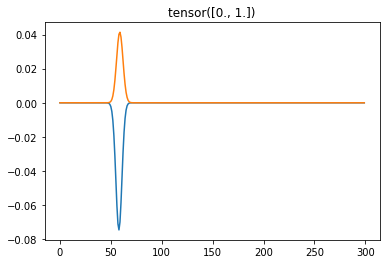

In [406]:
%matplotlib inline
for i in range(1):
    plt.plot(torch_T[i].detach().numpy()[0])
    plt.plot(torch_T[i].detach().numpy()[1])
    plt.title(torch_labels[i])
    plt.show()

# E2E

<IPython.core.display.Javascript object>


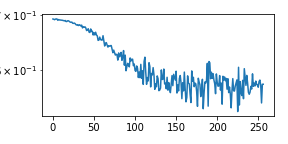

/home/alg010/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


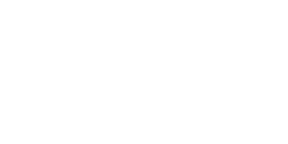

In [407]:
%matplotlib notebook
n_epochs = 1000
batch_size = 500
bar = tqdm(total=n_epochs)

fig = plt.figure(figsize=(4, 2))
ax_losses = plt.subplot(1, 1, 1)
plt_losses, = ax_losses.plot(range(len(losses)), losses)
ax_losses.set_yscale('log')

plt.tight_layout()

def power(spec):
    return numpy.sqrt(spec[0].detach().numpy() ** 2 + spec[1].detach().numpy() ** 2)

for e in (range(n_epochs)):
    subset = torch.randperm(len(torch_X))[:batch_size]
    torch_X_ = torch_X_conv[subset]
    torch_T_ = torch_labels[subset]

    optimiser_e2e.zero_grad()
    results = e2e.forward(torch_X_)
    loss = e2e.loss_fn(results, torch_T_)
    loss.backward()
    optimiser_e2e.step()
    losses_e2e.append(loss.item())
    
    accuracy = (results.argmax(dim=1) == torch_T_.argmax(dim=1)).float().mean()
    bar.postfix = '{:0.1%}'.format(accuracy.item())
    bar.update(1)

    plt_losses.set_data(range(len(losses_e2e)), losses_e2e)
    ax_losses.relim()
    ax_losses.autoscale_view()

    fig.canvas.draw()

# Deconvolving autoencoder

<IPython.core.display.Javascript object>


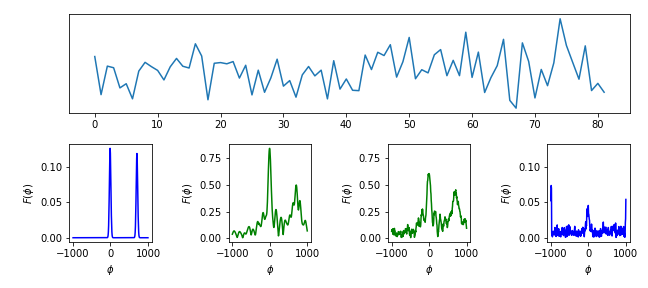

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


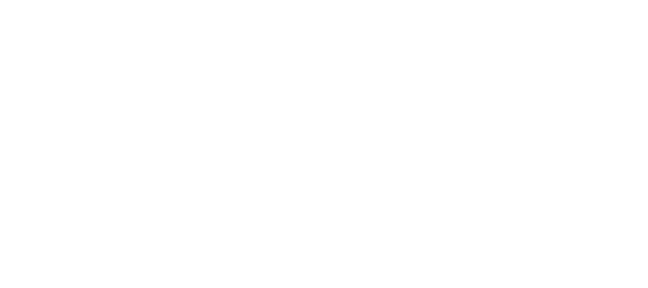

In [409]:
%matplotlib notebook
n_epochs = 1000
batch_size = 500
bar = tqdm(total=n_epochs)

fig = plt.figure(figsize=(9, 4))
ax_losses = plt.subplot2grid((2, 4), (0, 0), colspan=4)
plt_losses, = ax_losses.plot(range(len(losses)), losses)
ax_losses.set_yscale('log')
ax_init = plt.subplot2grid((2, 4), (1, 0))
ax_init.set_xlabel('$\\phi$')
ax_init.set_ylabel('$F(\\phi)$')
plt_init, = ax_init.plot(phis, phis, c='blue')
ax_conv = plt.subplot2grid((2, 4), (1, 1))
ax_conv.set_xlabel('$\\phi$')
ax_conv.set_ylabel('$F(\\phi)$')
plt_conv, = ax_conv.plot(phis, phis, c='green')
ax_recon = plt.subplot2grid((2, 4), (1, 2))
ax_recon.set_xlabel('$\\phi$')
ax_recon.set_ylabel('$F(\\phi)$')
plt_recon, = ax_recon.plot(phis, phis, c='green')
ax_deconv = plt.subplot2grid((2, 4), (1, 3))
ax_deconv.set_xlabel('$\\phi$')
ax_deconv.set_ylabel('$F(\\phi)$')
plt_deconv, = ax_deconv.plot(phis, phis, c='blue')

plt.tight_layout()

def power(spec):
    return numpy.sqrt(spec[0].detach().numpy() ** 2 + spec[1].detach().numpy() ** 2)

for e in (range(n_epochs)):
    # Train on the newly-generated spectra.
    subset = torch.randperm(len(torch_X))[:batch_size]
    torch_X_ = torch_X[subset]
    torch_T_ = torch_T[subset]

    optimiser.zero_grad()
    recons = dcae.forward(torch_X_)
    loss = dcae.loss(torch_T_, *recons, alpha=0.5)
    loss.backward()
    optimiser.step()
    losses_dcae.append(loss.item())
    bar.postfix = '{:0.4e}'.format(loss.item())
    bar.update(1)

    plt_losses.set_data(range(len(losses_dcae)), losses_dcae)
    ax_losses.relim()
    ax_losses.autoscale_view()

    plt_init.set_ydata(power(torch_T_[0]))
    ax_init.relim()
    ax_init.autoscale_view()

    plt_conv.set_ydata(power(recons[0][0]))
    ax_conv.relim()
    ax_conv.autoscale_view()

    plt_recon.set_ydata(power(recons[1][0]))
    ax_recon.set_ylim(ax_conv.get_ylim())
    ax_recon.autoscale_view()

    plt_deconv.set_ydata(power(recons[2][0]))
    ax_deconv.set_ylim(ax_init.get_ylim())
    ax_deconv.autoscale_view()

    fig.canvas.draw()

In [ ]:
# %matplotlib inline
# plt.plot(spectra_blurred[3].T)
# # plt.plot(spectra_noisy[3].T)

## Plots

In [368]:
torch.cuda.empty_cache()
for k, v in dict(locals()).items():
    if isinstance(v, torch.Tensor):
        print(k, v.size())

# del torch_X_
# del torch_T_
# del loss
# del subset
# del v
# del torch_T
del v

___ torch.Size([500, 2])
torch_X torch.Size([10000, 2, 300])
torch_T torch.Size([10000, 2, 300])
subset torch.Size([500])
torch_X_conv torch.Size([10000, 2, 300])
torch_X_ torch.Size([500, 2, 300])
torch_T_ torch.Size([500, 2])
_63 torch.Size([10000, 600])
loss torch.Size([])
torch_labels torch.Size([10000, 2])
_208 torch.Size([10000])
_209 torch.Size([10000])
_210 torch.Size([10000])
_212 torch.Size([10000])
results torch.Size([500, 2])
_216 torch.Size([10000, 1])
_222 torch.Size([10000, 1])
_224 torch.Size([500, 1])
_228 torch.Size([10000, 1])
_231 torch.Size([20000, 1])
_244 torch.Size([500, 2])
_346 torch.Size([500, 2])
_347 torch.Size([500, 2])
_349 torch.Size([500, 2])
accuracy torch.Size([])


In [369]:
recon = dcae.forward(torch_X)

In [370]:
[r.shape for r in recon]

[torch.Size([10000, 2, 300]),
 torch.Size([10000, 2, 300]),
 torch.Size([10000, 2, 300])]

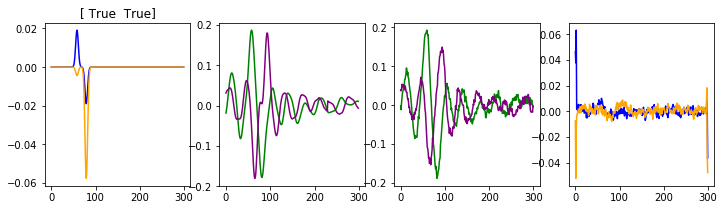

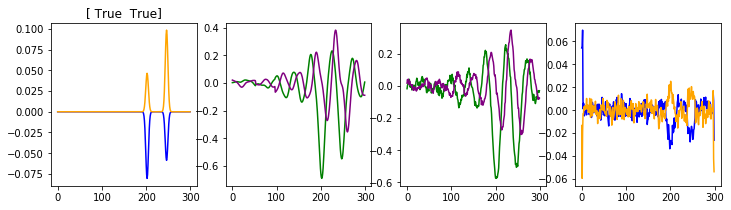

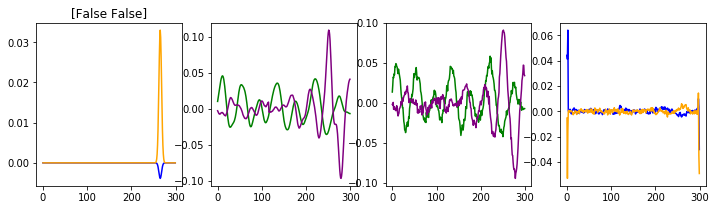

In [371]:
%matplotlib inline
for i in range(3):
    plt.figure(figsize=(12, 3))
    plt.subplot(1, 4, 1)
    plt.title(torch_labels[i].detach().numpy() == [0, 1])
    plt.plot(torch_T[i][0].detach().numpy(), c='blue')
    plt.plot(torch_T[i][1].detach().numpy(), c='orange')
    plt.subplot(1, 4, 2)
    plt.plot(recon[0][i][0].detach().numpy(), c='green')
    plt.plot(recon[0][i][1].detach().numpy(), c='purple')
    plt.subplot(1, 4, 3)
    plt.plot(recon[1][i][0].detach().numpy(), c='green')
    plt.plot(recon[1][i][1].detach().numpy(), c='purple')
    plt.subplot(1, 4, 4)
    plt.plot(recon[2][i][0].detach().numpy(), c='blue')
    plt.plot(recon[2][i][1].detach().numpy(), c='orange')
    plt.show()

## Testing the autoencoders

In [389]:
labels = simple
print(labels)
encoding_dirty = dcae.encode_dirty(torch_X).detach().numpy()
encoding_clean = dcae.encode_clean(torch_X).detach().numpy()

[False False  True ... False False  True]


In [394]:
encoding_e2e = e2e.conv(torch_X_conv).view(-1, 16 * 300).detach().numpy()

In [387]:
encoding_recon = dcae.forward(torch_X)[-1].detach().numpy()

In [388]:
encoding_recon = encoding_recon.reshape((encoding_recon.shape[0], -1))

In [377]:
def test_extracted_features(features, labels):
    train_X, test_X, train_Y, test_Y = sklearn.model_selection.train_test_split(
        features, labels, test_size=0.2, shuffle=True, stratify=labels)
    clf = sklearn.linear_model.LogisticRegression()
    clf.fit(train_X, train_Y)
    
    return {
        'cm_train': sklearn.metrics.confusion_matrix(train_Y, clf.predict(train_X)),
        'cm_test': sklearn.metrics.confusion_matrix(test_Y, clf.predict(test_X)),
        'acc_train': sklearn.metrics.accuracy_score(train_Y, clf.predict(train_X)),
        'acc_test': sklearn.metrics.accuracy_score(test_Y, clf.predict(test_X)),
    }

In [395]:
test_extracted_features(encoding_e2e, labels)

{'cm_train': array([[2879, 1099],
        [1130, 2892]]), 'cm_test': array([[683, 312],
        [301, 704]]), 'acc_train': 0.721375, 'acc_test': 0.6935}

In [390]:
test_extracted_features(encoding_dirty, labels)

{'cm_train': array([[1996, 1982],
        [1661, 2361]]), 'cm_test': array([[482, 513],
        [435, 570]]), 'acc_train': 0.544625, 'acc_test': 0.526}

In [391]:
test_extracted_features(encoding_clean, labels)

{'cm_train': array([[1895, 2083],
        [1532, 2490]]), 'cm_test': array([[455, 540],
        [404, 601]]), 'acc_train': 0.548125, 'acc_test': 0.528}

In [392]:
test_extracted_features(encoding_recon, labels)

{'cm_train': array([[1771, 2207],
        [1361, 2661]]), 'cm_test': array([[443, 552],
        [349, 656]]), 'acc_train': 0.554, 'acc_test': 0.5495}

In [383]:
test_extracted_features(pca_features, labels)

{'cm_train': array([[2015, 1963],
        [1649, 2373]]), 'cm_test': array([[459, 536],
        [409, 596]]), 'acc_train': 0.5485, 'acc_test': 0.5275}

In [384]:
test_extracted_features(spectra_conv_, labels)

{'cm_train': array([[1979, 1999],
        [1664, 2358]]), 'cm_test': array([[450, 545],
        [408, 597]]), 'acc_train': 0.542125, 'acc_test': 0.5235}

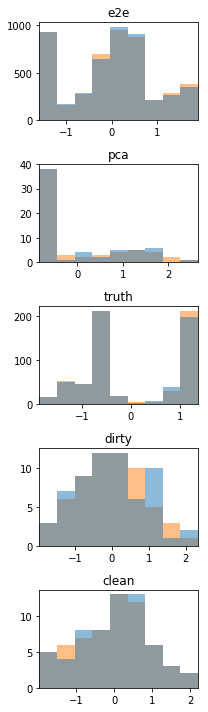

In [398]:
%matplotlib inline
plt.figure(figsize=(3, 10))
for i, name, features in zip(
        range(1, 6),
        ['e2e', 'pca', 'truth', 'dirty', 'clean', 'recon'],
        [encoding_e2e, pca_features, spectra_conv_, encoding_dirty, encoding_clean, encoding_recon]):
    mean_pos = features[labels > 0].std(axis=0)
    mean_neg = features[labels <= 0].std(axis=0)
    mean_pos -= mean_pos.mean()
    mean_pos /= mean_pos.std()
    mean_neg -= mean_neg.mean()
    mean_neg /= mean_neg.std()
    plt.subplot(5, 1, i)
    lim = (numpy.percentile(mean_pos, 1), numpy.percentile(mean_pos, 99))
    plt.hist([mean_pos, mean_neg], histtype='stepfilled', bins=numpy.linspace(*lim, 10), alpha=0.5)
    plt.xlim(lim)
    plt.title(name)
plt.tight_layout()

## Dump features

In [411]:
for name, features in zip(
        ['e2e', 'pca', 'truth', 'dirty', 'clean', 'recon'],
        [encoding_e2e, pca_features, spectra_conv_, encoding_dirty, encoding_clean, encoding_recon]):
    numpy.save('encoded_features_{}.npy'.format(name), features)

In [412]:
numpy.save('labels.npy', labels)